### WORK IN PROGRESS

Rotation vs Angle difference?!
We likely don't need rotation in the sphere, but rather subtraction of the angles.

In [1]:
%matplotlib qt 
# inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import random

# sth else https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/897677#897677


In [2]:
def rotate_align(v1,v2):
    '''
    Credit: https://gist.github.com/kevinmoran/b45980723e53edeb8a5a43c49f134724
    
    '''
    
    axis = np.cross(v1,v2)
    
    cosA = np.dot(v1,v2)
    
    k = 1.0 / (1.0 + cosA)
    
    print("cosA" + str(cosA))
    print("axis" + str(axis))
    
    result = np.array([[(axis[0] * axis[0] * k) + cosA, \
                        (axis[1] * axis[0] * k) - axis[2], \
                        (axis[2] * axis[0] * k) + axis[1]], \
                        [(axis[0] * axis[1] * k) + axis[2], \
                        (axis[1] * axis[1] * k) + cosA,     \
                        (axis[2] * axis[1] * k) - axis[0]], \
                        [(axis[0] * axis[2] * k) - axis[1], \
                        (axis[1] * axis[2] * k) + axis[0],  \
                        (axis[2] * axis[2] * k) + cosA]])
    return result



def calculate_thetas_from_unity_coords(dir_vec,ret_degree=True):
    '''
    Calculates the horizontal and vertical angles of the direction vector. 
    Coordinate system: X to the right, Y up, Z forward.    
    Refers to Unity coordinates.
    '''
    
    theta_horizontal = np.arctan2(dir_vec[0], dir_vec[2])
    theta_vertical = np.arctan2(dir_vec[1], dir_vec[2])
    
    if ret_degree:
        theta_horizontal = theta_horizontal / 2 / np.pi * 360
        theta_vertical = theta_vertical / 2 / np.pi * 360
    
    return theta_horizontal, theta_vertical 


def calculate_rotation_matrix(rotate_around_axis, angle, angle_in_degree=True):
    '''
    Calculate a rotation matrix around a specified axis.
    Possible values for rotate_around_axis: 'x', 'y', 'z'. 
    Refers to a right-handed cartesian coordinate system. 
    
    https://en.wikipedia.org/wiki/Rotation_matrix 
    '''
    
    rot_mat = None
     
    if rotate_around_axis.lower() == 'x': 
        theta_x = angle
        if angle_in_degree:
            theta_x = theta_x / 360 * np.pi * 2 
        rot_mat_x = np.array([
            [1,0,0],
            [0,np.cos(theta_x),-np.sin(theta_x)],
            [0,np.sin(theta_x),np.cos(theta_x)]
        ])
        rot_mat = rot_mat_x
    
    elif rotate_around_axis.lower() == 'y':
        theta_y = angle
        if angle_in_degree:
            theta_y = theta_y / 360 * np.pi * 2 
        rot_mat_y = np.array([
            [np.cos(theta_y),0,np.sin(theta_y)],
            [0,1,0],
            [-np.sin(theta_y),0,np.cos(theta_y)]
        ])
        rot_mat = rot_mat_y
        
    elif rotate_around_axis.lower() == 'z':  
        theta_z = angle
        if angle_in_degree:
            theta_z = theta_z / 360 * np.pi * 2 
        rot_mat_z = np.array([
            [np.cos(theta_z),-np.sin(theta_z),0],
            [np.sin(theta_z),np.cos(theta_z),0],
            [0,0,1]
        ])
        rot_mat = rot_mat_z
        
    else:
        print("Incorrect axis specified!")
    
    return rot_mat

def unity_pts_to_right_handed_cartesian_coords(pts):
    '''
    Transforms multiple points in Unity coordinates to
    right-handed cartesian coordinates.
    '''
    
    transformed_pts = []
    
    for elem in pts:
        transformed_pts.append([elem[0],elem[2],elem[1]]) # y and z are switched
    
    return transformed_pts 
    
    
def angle_between(v1, v2, degree=True):
    
    v1_u = v1 / np.linalg.norm(v1) # unit vector
    v2_u = v2 / np.linalg.norm(v2) # unit vector
    
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
    if degree:
        angle = angle / 2 / np.pi * 360
    
    return angle   


def angle_in_180s(angle):
    
    angle = angle % 360
    
    if angle > 180:
        angle = -1 * (360 - angle)
    elif angle < -180:
        angle = 360 + angle
    
    return angle



    
def cart2sph(vec):
    '''
    Cartesian coordinates to spherical coordinates.
    https://github.com/numpy/numpy/issues/5228#issue-46746558
    '''
    x = vec[0]
    y = vec[1]
    z = vec[2]
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

def sph2cart(az, el, r):
    '''
    Spherical coordinates to cartesian coordinates.
    Azimuth on groundplane, elevation from groundplane to up-axis. 
    https://github.com/numpy/numpy/issues/5228#issue-46746558
    '''
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

def deg2rad(angle):
    return angle / 360 * 2* np.pi

def rad2deg(angle):
    return angle / 2 / np.pi * 360 

In [12]:


fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1, projection='3d')

# forward 
forward_dir_unity = np.array([0,0,1])

# inputs
inp_dir_unity = np.array([1,1,1])
ref_dir_unity = np.array([-1,-1,1])

# generate random data as input and reference in (-1,1)
inp_dir_unity = np.array([random.random() * 2 - 1 for _ in range(3)])
ref_dir_unity = np.array([random.random() * 2 - 1 for _ in range(3)]) 

# compute cartesian right-handed representation 
inp_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([inp_dir_unity])[0]
ref_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([ref_dir_unity])[0]
forward_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([forward_dir_unity])[0]

#### 
#inp_dir_cartesian = np.array([0.4609944825876826, 0.1321670315678083, -0.4489406317631861])
#ref_dir_cartesian = np.array([-0.20632662366938836, -0.36921655868324166, 0.36551083215510016])

inp_dir_cartesian = np.array([0, 1, 1])
ref_dir_cartesian = np.array([0, 0, -1])



# 	Final: (-0.07434771588387001, -0.07485562075919719, -0.994418952546464)



# compute spherical coordinates 
inp_dir_spherical = cart2sph(inp_dir_cartesian)
ref_dir_spherical = cart2sph(ref_dir_cartesian) 
forward_dir_spherical = cart2sph(forward_dir_cartesian)

# compute difference and add to forward dir 
final_dir_spherical = (inp_dir_spherical[0] - ref_dir_spherical[0], inp_dir_spherical[1] - ref_dir_spherical[1], 1)
#print("inp" + str(inp_dir_spherical))
#print("ref" + str(ref_dir_spherical))
#print("final" + str(final_dir_spherical))
final_dir_spherical = (final_dir_spherical[0] + forward_dir_spherical[0], final_dir_spherical[1] + forward_dir_spherical[1],1)
#print(final_dir_spherical)


# convert final direction back to cartesian coordinates
final_dir_cartesian = sph2cart(*final_dir_spherical)

# verify vectors and directions 
inp_vert_angle = angle_between(inp_dir_cartesian,[inp_dir_cartesian[0],inp_dir_cartesian[1],0]) # angle between vec and projection on xy-plane (cartesian)
inp_horiz_angle = angle_between([inp_dir_cartesian[0],inp_dir_cartesian[1],0],[0,1,0]) # angle between projection on xy-plane and forward vector (cartesian)

ref_vert_angle = angle_between(ref_dir_cartesian,[ref_dir_cartesian[0],ref_dir_cartesian[1],0]) # angle between vec and projection on xy-plane (cartesian)
ref_horiz_angle = angle_between([ref_dir_cartesian[0],ref_dir_cartesian[1],0],[0,1,0]) # angle between projection on xy-plane and forward vector (cartesian)

final_vert_angle = angle_between(final_dir_cartesian,[final_dir_cartesian[0],final_dir_cartesian[1],0]) # angle between vec and projection on xy-plane (cartesian)
final_horiz_angle = angle_between([final_dir_cartesian[0],final_dir_cartesian[1],0],[0,1,0]) # angle between projection on xy-plane and forward vector (cartesian)

# if z (cartesian) is negative, vertical angle is negative 
if inp_dir_cartesian[2] < 0:
    inp_vert_angle *= -1
if ref_dir_cartesian[2] < 0:
    ref_vert_angle *= -1
if final_dir_cartesian[2] < 0:
    final_vert_angle *= -1

# if x (cartesian) is negative, horizontal angle is negative 
if inp_dir_cartesian[0] < 0:
    inp_horiz_angle *= -1
if ref_dir_cartesian[0] < 0:
    ref_horiz_angle *= -1
if final_dir_cartesian[0] < 0:
    final_horiz_angle *= -1

# print verification infos 
print("Horizontal angles:")
print("\tInput: " + str(inp_horiz_angle))
print("\tReference: " + str(ref_horiz_angle))
print("\tFinal: " + str(final_horiz_angle))
print("Vertical angles:")
print("\tInput: " + str(inp_vert_angle))
print("\tReference:" + str(ref_vert_angle))
print("\tFinal: " + str(final_vert_angle))
print("Vectors:")
print("\tInput: " + str(inp_dir_cartesian))
print("\tReference: " + str(ref_dir_cartesian))
print("\tFinal: " + str(final_dir_cartesian))


# Plot
ax1.quiver(0,0,0,2,0,0,color="black") # axis
ax1.quiver(0,0,0,0,2,0,color="black") # axis
ax1.quiver(0,0,0,0,0,2,color="black") # axis
ax1.quiver(0,0,0,inp_dir_cartesian[0],inp_dir_cartesian[1],inp_dir_cartesian[2],color="green") # input
ax1.quiver(0,0,0,ref_dir_cartesian[0],ref_dir_cartesian[1],ref_dir_cartesian[2],color="blue") # reference
ax1.quiver(0,0,0,final_dir_cartesian[0],final_dir_cartesian[1],final_dir_cartesian[2],color="red") # final

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
ax1.set_zlim(-2.5,2.5)
ax1.set_xlabel("Unity X / Cartesian x")
ax1.set_ylabel("Unity Z / Cartesian y")
ax1.set_zlabel("Unity Y / Cartesian z")

ax1.scatter(0,0,0,marker=".",color="black",s=500)

plt.show()

Horizontal angles:
	Input: 0.0
	Reference: nan
	Final: 90.0
Vertical angles:
	Input: 45.00000000000001
	Reference:nan
	Final: 45.00000000000001
Vectors:
	Input: [0 1 1]
	Reference: [ 0  0 -1]
	Final: (0.7071067811865475, -8.659560562354932e-17, 0.7071067811865476)


<ipython-input-2-80e533ffe5c6>:112: RuntimeWarning: invalid value encountered in true_divide
  v2_u = v2 / np.linalg.norm(v2) # unit vector
<ipython-input-2-80e533ffe5c6>:111: RuntimeWarning: invalid value encountered in true_divide
  v1_u = v1 / np.linalg.norm(v1) # unit vector


In [26]:
# Version 2
# Basic idea
# Find rotations around z (cartesian, Unity y) and subsequently x (cartesian, Unity x) 
# that would rotate reference vector to forward direction (Unity 0,0,1). 
# Apply those rotations to reference vector, but also to input vector.
# Resulting rotated input vector is final direction relative to forward vector. 
print("Version 2")

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1, projection='3d')

# Input and reference 
#inp_dir_unity = np.array([1,-0.5,0.1])
#ref_dir_unity = np.array([-0.2,1,0.8])
#inp_dir_unity = np.array([-1,1.5,0.3])
#ref_dir_unity = np.array([-0.2,-1,0.8])
inp_dir_unity = np.array([-1,0,1])
ref_dir_unity = np.array([0,-1,-1])



# To cartesian from Unity 
inp_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([inp_dir_unity])[0]
ref_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([ref_dir_unity])[0]

# Calculate horizontal angle offset as angle between direction vector's projection on x,y plane (cartesian) and forward vector
# Alternatively, use calculate_thetas_from_unity_coords (but can only use horizontal value here, because projection would skew vertical value)
ref_horizontal = angle_between([ref_dir_cartesian[0],ref_dir_cartesian[1],0],[0,1,0])

# Calculate vertical angle offset as angle between direction vector and projection on x,y plane (cartesian)
ref_vertical = angle_between(ref_dir_cartesian,[ref_dir_cartesian[0],ref_dir_cartesian[1],0])

# if z (cartesian) is negative, vertical angle is negative 
if ref_dir_cartesian[2] < 0:
    ref_vertical *= -1
    
# if x (cartesian) is negative, horizontal angle is negative 
if ref_dir_cartesian[0] < 0:
    ref_horizontal *= -1
    
# Calculate horizontal angle offset for input 
inp_horizontal = angle_between([inp_dir_cartesian[0],inp_dir_cartesian[1],0],[0,1,0])

# Calculate vertical angle offset for input
inp_vertical = angle_between(inp_dir_cartesian,[inp_dir_cartesian[0],inp_dir_cartesian[1],0])

# if z (cartesian) is negative, vertical angle is negative 
if inp_dir_cartesian[2] < 0:
    inp_vertical *= -1
    
# if x (cartesian) is negative, horizontal angle is negative 
if inp_dir_cartesian[0] < 0:
    inp_horizontal *= -1

print("Reference horizontal: " + str(ref_horizontal))
print("Reference vertical: " + str(ref_vertical))
print("Input horizontal: " + str(inp_horizontal))
print("Input vertical: " + str(inp_vertical))

# calculate rot matrices
# axis are for right-handed coordinate system
# ?? angle inverted for horizontal
horizontal_rot_mat = calculate_rotation_matrix(rotate_around_axis="z", angle= ref_horizontal, angle_in_degree=True)
vertical_rot_mat = calculate_rotation_matrix(rotate_around_axis="x", angle= -1 *ref_vertical, angle_in_degree=True)


# Apply calculated rotations to reference direction, in order to rotate it to forward direction (Unity 0,0,1)
# First horizontal, then vertical! Rotation axis must align 
rotated_ref = ref_dir_cartesian.copy()
rotated_ref = np.dot(horizontal_rot_mat,rotated_ref)
rotated_ref = np.dot(vertical_rot_mat, rotated_ref)


# Calculate horizontal angle offset of rotated reference
rotated_ref_horizontal = angle_between([rotated_ref[0],rotated_ref[1],0],[0,1,0])

# Calculate vertical angle offset of rotated reference
rotated_ref_vertical = angle_between(rotated_ref,[rotated_ref[0],rotated_ref[1],0])

# if z (cartesian) is negative, vertical angle is negative 
if rotated_ref[2] < 0:
    rotated_ref_vertical *= -1
    
# if x (cartesian) is negative, horizontal angle is negative 
if ref_dir_cartesian[0] < 0:
    rotated_ref_horizontal *= -1

print("Rotated reference horizontal: " + str(rotated_ref_horizontal))
print("Rotated reference vertical: " + str(rotated_ref_vertical))



# Apply calculated rotations to input direction
# Same order, as for reference. First horizontal, then vertical! Rotation axis must align 
rotated_inp = inp_dir_cartesian.copy()
rotated_inp = np.dot(horizontal_rot_mat,rotated_inp)
rotated_inp = np.dot(vertical_rot_mat, rotated_inp)


# Calculate horizontal angle offset of rotated input
rotated_inp_horizontal = angle_between([rotated_inp[0],rotated_inp[1],0],[0,1,0])

# Calculate vertical angle offset of rotated input
rotated_inp_vertical = angle_between(rotated_inp,[rotated_inp[0],rotated_inp[1],0])

# if z (cartesian) is negative, vertical angle is negative 
if rotated_inp[2] < 0:
    rotated_inp_vertical *= -1
    
# if x (cartesian) is negative, horizontal angle is negative 
if rotated_inp[0] < 0:
    rotated_inp_horizontal *= -1

print("Rotated input horizontal: " + str(rotated_inp_horizontal))
print("Rotated input vertical: " + str(rotated_inp_vertical))




# Plot
ax1.quiver(0,0,0,2,0,0,color="black") # axis
ax1.quiver(0,0,0,0,2,0,color="black") # axis
ax1.quiver(0,0,0,0,0,2,color="black") # axis
ax1.quiver(0,0,0,inp_dir_cartesian[0],inp_dir_cartesian[1],inp_dir_cartesian[2],color="green") # input
ax1.quiver(0,0,0,ref_dir_cartesian[0],ref_dir_cartesian[1],ref_dir_cartesian[2],color="blue") # reference
ax1.quiver(0,0,0,rotated_ref[0],rotated_ref[1],rotated_ref[2],color="lightblue") # reference rotated
ax1.quiver(0,0,0,rotated_inp[0],rotated_inp[1],rotated_inp[2],color="lightgreen") # input rotated

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
ax1.set_zlim(-2.5,2.5)
ax1.set_xlabel("Unity x (x)")
ax1.set_ylabel("Unity z (y)")
ax1.set_zlabel("Unity y (z)")

ax1.scatter(0,0,0,marker=".",color="black",s=500)

plt.show()

Version 2
Reference horizontal: 180.0
Reference vertical: -45.00000000000001
Input horizontal: -45.00000000000001
Input vertical: 1.2074182697257333e-06
Rotated reference horizontal: 0.0
Rotated reference vertical: 0.0
Rotated input horizontal: 125.26438968275465
Rotated input vertical: -30.000000000000004


In [8]:
# Version 1
#
# Basic idea
# Difference of elevation angle between reference and input 
# Difference of horizontal angle between reference and input 
# Apply angle difference to forward direction 
# Is likely not the same as rotating reference direction to forward direction 
# and applying same rotations to input  

print("Version 1")


fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1, projection='3d')

# Input and reference 
inp_dir_unity = np.array([1,-0.5,0.1])
ref_dir_unity = np.array([-0.2,1,0.8])

# To cartesian from Unity 
inp_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([inp_dir_unity])[0]
ref_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([ref_dir_unity])[0]

# Calculate thetas, can only use horizontal, since vertical depends on different plane than projected one 
inp_horizontal, _ = calculate_thetas_from_unity_coords(inp_dir_unity,ret_degree=True)
ref_horizontal, _ = calculate_thetas_from_unity_coords(ref_dir_unity,ret_degree=True)

# Calculate vertical angle offset as angle between direction vector and projection on x,y plane (cartesian)
inp_vertical = angle_between(inp_dir_cartesian,[inp_dir_cartesian[0],inp_dir_cartesian[1],0])
ref_vertical = angle_between(ref_dir_cartesian,[ref_dir_cartesian[0],ref_dir_cartesian[1],0])


# if z (cartesian) is negative, vertical angle is negative 
if inp_dir_cartesian[2] < 0:
    inp_vertical *= -1
if ref_dir_cartesian[2] < 0:
    ref_vertical *= -1


# Calculate angle offsets 
offset_horizontal = inp_horizontal - ref_horizontal
offset_vertical = inp_vertical - ref_vertical


print("Input horizontal: " + str(inp_horizontal))
print("Reference horizontal: " + str(ref_horizontal))
print("Input vertical: " + str(inp_vertical))
print("Reference vertical: " + str(ref_vertical))
print("Offset horizontal: " + str(offset_horizontal)) # rotate around Unity y, Right-Handed cartesian z
print("Offset vertical: " + str(offset_vertical)) # rotate around Unity/ Right-Handed cartesian x 

# calculate rot matrices
# axis are for right-handed coordinate system
# angle inverted for horizontal
horizontal_rot_mat = calculate_rotation_matrix(rotate_around_axis="z", angle= -1 * offset_horizontal, angle_in_degree=True)
vertical_rot_mat = calculate_rotation_matrix(rotate_around_axis="x", angle=offset_vertical, angle_in_degree=True)


# apply calculated relative rotations to forward Unity vector (0,0,1) (in right-handed cartesian (0,1,0)) to get final direction 
# first vertical, then horizontal! Rotation axis must align 
final_dir_unity = np.array([0,0,1])
final_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([final_dir_unity])[0]
final_dir_cartesian = np.dot(vertical_rot_mat, final_dir_cartesian)
final_dir_cartesian = np.dot(horizontal_rot_mat,final_dir_cartesian)
final_dir_cartesian = np.array([0,0,0,final_dir_cartesian[0],final_dir_cartesian[1],final_dir_cartesian[2]])


# Plot
ax1.quiver(0,0,0,2,0,0,color="black") # axis
ax1.quiver(0,0,0,0,2,0,color="black") # axis
ax1.quiver(0,0,0,0,0,2,color="black") # axis
ax1.quiver(0,0,0,inp_dir_cartesian[0],inp_dir_cartesian[1],inp_dir_cartesian[2],color="green") # input
ax1.quiver(0,0,0,ref_dir_cartesian[0],ref_dir_cartesian[1],ref_dir_cartesian[2],color="blue") # reference
ax1.quiver(final_dir_cartesian[0],final_dir_cartesian[1],final_dir_cartesian[2],final_dir_cartesian[3],final_dir_cartesian[4],final_dir_cartesian[5],color="red") # final

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
ax1.set_zlim(-2.5,2.5)
ax1.set_xlabel("Unity x (x)")
ax1.set_ylabel("Unity z (y)")
ax1.set_zlabel("Unity y (z)")

ax1.scatter(0,0,0,marker=".",color="black",s=500)

plt.show()

Input horizontal: 84.28940686250036
Reference horizontal: -14.036243467926479
Input vertical: -26.451199099340613
Reference vertical: 50.49028771380608
Offset horizontal: 98.32565033042684
Offset vertical: -76.9414868131467


### Experimental & Untested

From vec pre scaling: [ 1 -1 -1]
cosA-0.5773502691896258
axis[-0.57735027 -0.57735027  0.        ]
[[ 0.21132487  0.78867513 -0.57735027]
 [ 0.78867513  0.21132487  0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027]]
From vec scaled: [ 0.57735027 -0.57735027 -0.57735027]
[0 0 1]


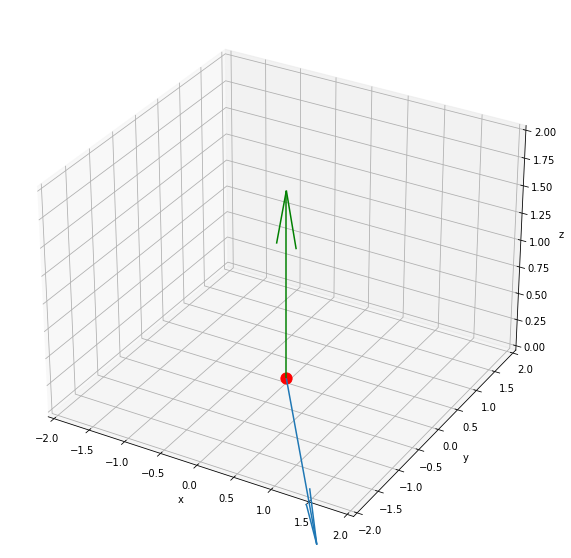

In [132]:

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1, projection='3d')

# from x,y,z to x,y,z
input_pts = np.array([[0,0,0,1,-1,-1]])
              #[0,0,0,1,-1,-1]])



# Use rotate from vector to vector method 

from_vec = input_pts[0][3:]
print("From vec pre scaling: " + str(from_vec))

from_vec = from_vec / np.linalg.norm(from_vec)
to_vec = np.array([0,0,1])
rot_mat_align = rotate_align(from_vec,to_vec)
print(rot_mat_align)

pts_new = np.dot(rot_mat_align,input_pts[0][3:])





print("From vec scaled: " + str(from_vec))
print(to_vec)

ax1.quiver(input_pts[:,0],input_pts[:,1],input_pts[:,2],input_pts[:,3],input_pts[:,4],input_pts[:,5])
ax1.quiver(0,0,0,pts_new[0],pts_new[1],pts_new[2],color="green")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax1.set_zlim(0,2)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax1.scatter(0,0,0,marker=".",color="red",s=500)

plt.show()




[[ 0.  0.  0. -1. -1.  1.]]


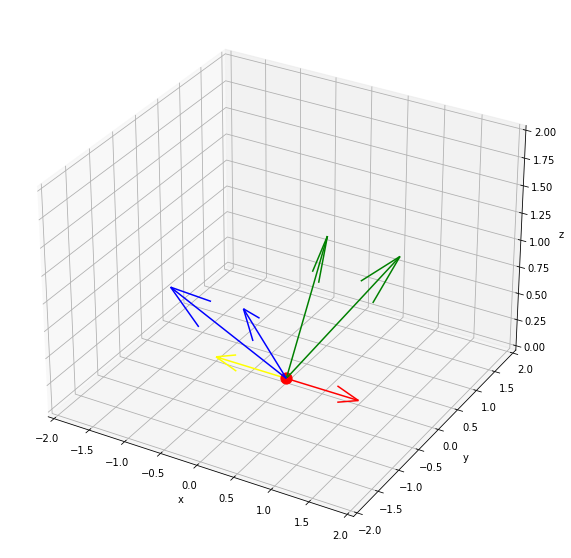

In [139]:
## Offsets 

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1, projection='3d')


first_vec = np.array([[0,0,0,1,1,1]])
second_vec = np.array([[0,0,0,0,1,1]])
offset_one = np.array([first_vec[0] - second_vec[0]])

theta_z = 180 / 360 * 2 * np.pi 
rot_mat_z = np.array([
    [np.cos(theta_z),-np.sin(theta_z),0],
    [np.sin(theta_z),np.cos(theta_z),0],
    [0,0,1]
])


pts_new = np.dot(rot_mat_z, first_vec[0][3:])
third_vec = np.array([[0,0,0,pts_new[0],pts_new[1],pts_new[2]]]) # np.array([[0,0,0,-1,-1,-1]])
pts_new = np.dot(rot_mat_z, second_vec[0][3:])
fourth_vec = np.array([[0,0,0,pts_new[0],pts_new[1],pts_new[2]]]) # np.array([[0,0,0,0,-1,-1]])

print(third_vec)
offset_two = np.array([third_vec[0] - fourth_vec[0]])

ax1.quiver(first_vec[:,0],first_vec[:,1],first_vec[:,2],first_vec[:,3],first_vec[:,4],first_vec[:,5], color = "green")
ax1.quiver(second_vec[:,0],second_vec[:,1],second_vec[:,2],second_vec[:,3],second_vec[:,4],second_vec[:,5], color = "green")
ax1.quiver(offset_one[:,0],offset_one[:,1],offset_one[:,2],offset_one[:,3],offset_one[:,4],offset_one[:,5], color = "red")

ax1.quiver(third_vec[:,0],third_vec[:,1],third_vec[:,2],third_vec[:,3],third_vec[:,4],third_vec[:,5], color = "blue")
ax1.quiver(fourth_vec[:,0],fourth_vec[:,1],fourth_vec[:,2],fourth_vec[:,3],fourth_vec[:,4],fourth_vec[:,5], color = "blue")
ax1.quiver(offset_two[:,0],offset_two[:,1],offset_two[:,2],offset_two[:,3],offset_two[:,4],offset_two[:,5], color = "yellow")


plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax1.set_zlim(0,2)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax1.scatter(0,0,0,marker=".",color="red",s=500)

plt.show()






In [ ]:
## 
## More rotations 


# Rotation around axis, right-hand rule 
theta_x = 90 / 360 * np.pi * 2 
theta_y = 90 / 360 * np.pi * 2 
theta_z = 45 / 360 * np.pi * 2 

rot_mat_x = np.array([
    [1,0,0],
    [0,np.cos(theta_x),-np.sin(theta_x)],
    [0,np.sin(theta_x),np.cos(theta_x)]
])
rot_mat_y = np.array([
    [np.cos(theta_y),0,np.sin(theta_y)],
    [0,1,0],
    [-np.sin(theta_y),0,np.cos(theta_y)]
])
rot_mat_z = np.array([
    [np.cos(theta_z),-np.sin(theta_z),0],
    [np.sin(theta_z),np.cos(theta_z),0],
    [0,0,1]
])

#pts_new = np.dot(rot_mat_z, input_pts[0][3:])
#pts_new = np.dot(rot_mat_x, pts_new)
#pts_new = np.dot(rot_mat_y, pts_new)



'''
# Create Rotation Matrix from rotation vector, perform angle shifts in rotation vector simultaneously
# Right hand rule 
rotvec = (-1 * offset_vertical,0,offset_horizontal)
#rotvec = (45,45,0) ## TODO 
r = R.from_rotvec(rotvec)
rot_mat_combined = r.as_matrix()
final_dir_unity = np.array([0,0,1])
final_dir_cartesian = unity_pts_to_right_handed_cartesian_coords([final_dir_unity])[0]
final_dir_cartesian = np.dot(rot_mat_combined, final_dir_cartesian)
final_dir_cartesian = np.array([0,0,0,final_dir_cartesian[0],final_dir_cartesian[1],final_dir_cartesian[2]])
'''


# Create Rotation Matrix from rotation vector, perform angle shifts in rotation vector simultaneously
# Right hand rule 
theta_x = 90 / 360 * 2 * np.pi
theta_z = 90 / 360 * 2 * np.pi
theta_y = 45 / 360 * 2 * np.pi 

rotvec = (theta_x,0,theta_z)

r = R.from_rotvec(rotvec)
rot_mat_combined = r.as_matrix()

#pts_new = np.dot(rot_mat_combined,input_pts[0][3:])